In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import ppscore as pps
import numpy as np
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from scipy.stats import shapiro
from sklearn.linear_model import ElasticNet

In [2]:
df_sales = pd.read_csv('./data/Advertising.csv')

In [3]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [4]:
df_sales.head(10)

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
5,6,8.7,48.9,75.0,7.2
6,7,57.5,32.8,23.5,11.8
7,8,120.2,19.6,11.6,13.2
8,9,8.6,2.1,1.0,4.8
9,10,199.8,2.6,21.2,10.6


In [5]:
df_sales.drop('Unnamed: 0', axis=1, inplace=True)

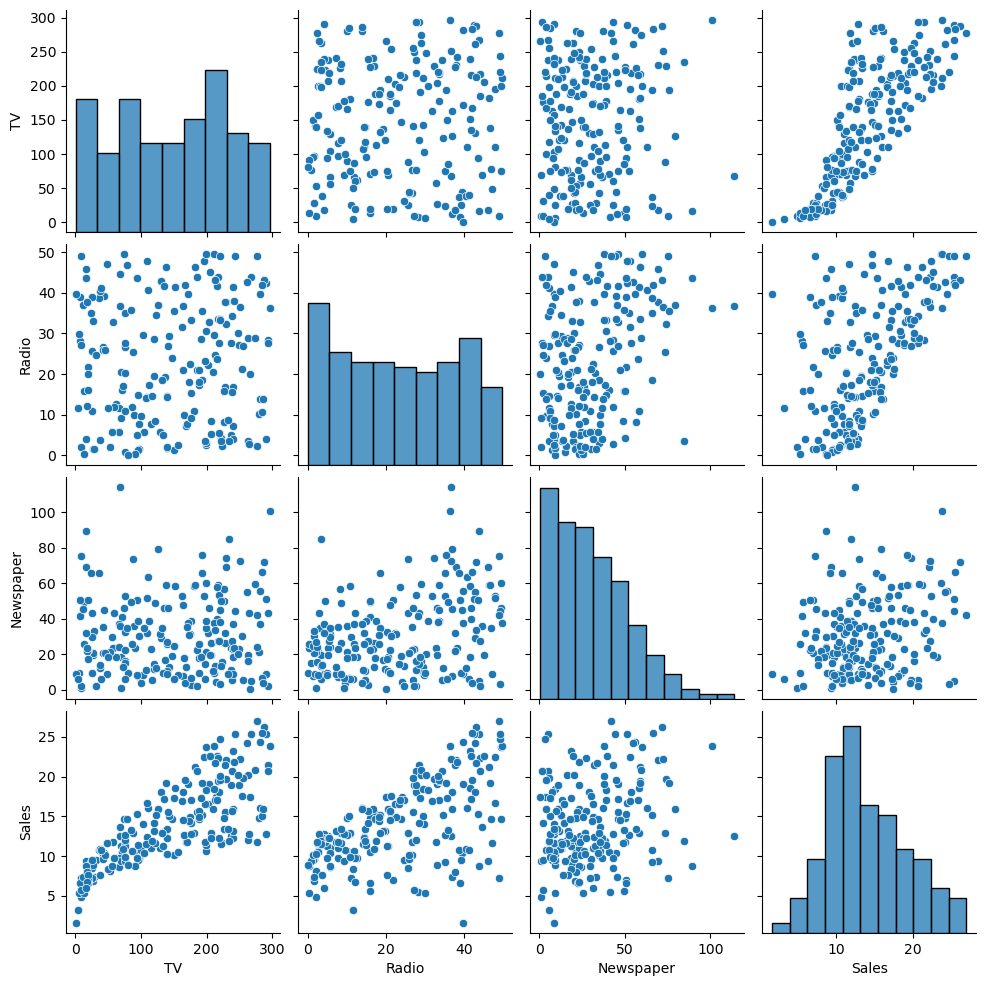

In [6]:
sns.pairplot(df_sales)

<Axes: >

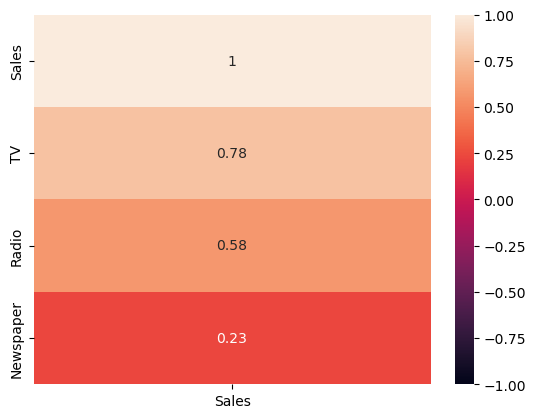

In [7]:
sns.heatmap(df_sales.corr('pearson')[['Sales']].sort_values('Sales', ascending=False), annot=True, vmin=-1, vmax=+1)

<Axes: >

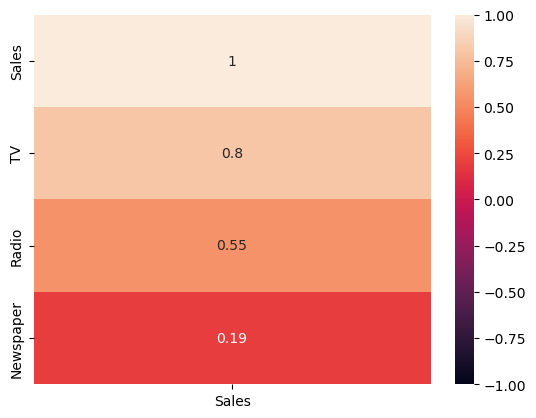

In [8]:
sns.heatmap(df_sales.corr('spearman')[['Sales']].sort_values('Sales', ascending=False), annot=True, vmin=-1, vmax=+1)

In [9]:
pps_matrix_reg = pps.matrix(df_sales)

pps_matrix_reg_pivot = pps_matrix_reg[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

<Axes: xlabel='x', ylabel='y'>

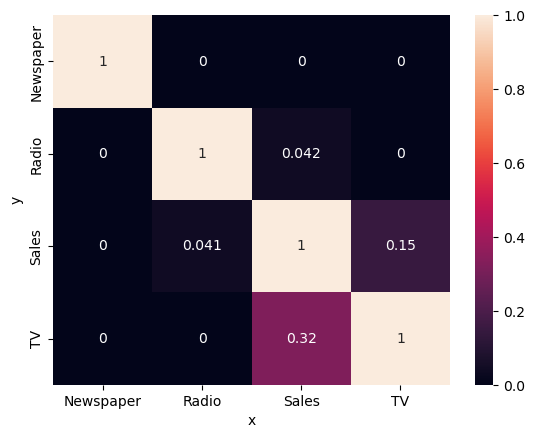

In [10]:
sns.heatmap(pps_matrix_reg_pivot, annot=True)

In [11]:
num_cols = ['Newspaper', 'Radio', 'TV']
X = df_sales.drop(columns=['Sales'], axis=1)
y = df_sales['Sales']


transformer = Pipeline(steps=[
    ('num', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('scaler', transformer, num_cols)
])

model_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores_list = []
mse_scores_list = []
mae_scores_list = []
residuos_list = []
residuos_std_list = []
y_pred_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_reg.fit(X_train, y_train)
    y_pred = model_reg.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    residuos = (y_test - y_pred)
    residuos_std = residuos / residuos.std()

    y_pred_list.append(y_pred)
    r2_scores_list.append(r2)
    mse_scores_list.append(mse)
    mae_scores_list.append(mae)
    residuos_list.append(residuos)
    residuos_std_list.append(residuos_std)

mae = np.mean(mae_scores_list)
mse = np.mean(mse_scores_list)
r2 = np.mean(r2_scores_list)
residuos = np.concatenate(residuos_list)
residuos_std = np.concatenate(residuos_std_list)
all_y_pred = np.concatenate(y_pred_list)

In [12]:
print("📊 Resultados das Métricas:")
print(f"------------------------------------")
print(f"Média do Erro Absoluto (MAE): {mae:.4f}")
print(f"Média do Erro Quadrático (MSE): {mse:.4f}")
print(f"Média do R² Score: {r2:.4f}")
print(f"------------------------------------")
print(f"Análise dos Resíduos:")
print(f"  Média dos Resíduos: {residuos.mean():.4f}")
print(f"  Desvio Padrão dos Resíduos: {residuos_std.mean():.4f}")
print(f"------------------------------------")
print(f"Previsões:")
print(f"  Média das Previsões: {all_y_pred.mean():.4f}")
print(f"  Desvio Padrão das Previsões: {all_y_pred.std():.4f}")

📊 Resultados das Métricas:
------------------------------------
Média do Erro Absoluto (MAE): 1.2873
Média do Erro Quadrático (MSE): 2.9651
Média do R² Score: 0.8827
------------------------------------
Análise dos Resíduos:
  Média dos Resíduos: 0.0046
  Desvio Padrão dos Resíduos: 0.0164
------------------------------------
Previsões:
  Média das Previsões: 14.0179
  Desvio Padrão das Previsões: 4.9220


In [31]:
transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=True, degree=1)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', transformer_poly, num_cols)
])

model_poly_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=10000))
])

param_grid = {
    'preprocessor__num__poly__degree': [1, 2, 3, 4],
    'regressor__alpha': [0.1, 1.0, 10.0, 100],
    'regressor__l1_ratio': [0.0, 0.5, 1.0, 10, 100]
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'R2': 'r2', 'MAE': 'neg_mean_absolute_error'}

grid_search = GridSearchCV(
    estimator=model_poly_reg,
    param_grid=param_grid,
    cv=kf,
    scoring=scoring,
    refit='MAE',
    verbose=1,
    n_jobs=-1  # Usa todos os núcleos do processador para acelerar
)

grid_search.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/home/aderson/miniconda3/envs/aprendendo/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e+02, tolerance: 4.150e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/aderson/miniconda3/envs/aprendendo/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.886e+02, tolerance: 4.566e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solv

,estimator,Pipeline(step...iter=10000))])
,param_grid,"{'preprocessor__num__poly__degree': [1, 2, ...], 'regressor__alpha': [0.1, 1.0, ...], 'regressor__l1_ratio': [0.0, 0.5, ...]}"
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2'}"
,n_jobs,-1
,refit,'MAE'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...)]"


In [53]:
print("\n--- Resultados da Otimização com GridSearchCV ---")
print(f"Melhor grau de polinômio encontrado: {grid_search.best_params_['preprocessor__num__poly__degree']}")
print(f"Melhor pontuação MAE (negativo): {grid_search.best_score_:.4f}")

# Podemos acessar os resultados completos de cada combinação
results_df = pd.DataFrame(grid_search.cv_results_)

results_df.dropna(inplace=True)
print("\nTabela completa de resultados (as 5 primeiras linhas):")
print(results_df[[
    'param_preprocessor__num__poly__degree', 
    'mean_test_R2', 
    'mean_test_MAE'
]].sort_values(by='mean_test_MAE', ascending=False).head())




--- Resultados da Otimização com GridSearchCV ---
Melhor grau de polinômio encontrado: 4
Melhor pontuação MAE (negativo): -0.5538

Tabela completa de resultados (as 5 primeiras linhas):
    param_preprocessor__num__poly__degree  mean_test_R2  mean_test_MAE
62                                      4      0.971296      -0.553832
42                                      3      0.970140      -0.574261
61                                      4      0.968055      -0.612421
41                                      3      0.966579      -0.632366
60                                      4      0.964108      -0.642932


In [54]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__poly__degree,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_R2,split1_test_R2,...,std_test_R2,rank_test_R2,split0_test_MAE,split1_test_MAE,split2_test_MAE,split3_test_MAE,split4_test_MAE,mean_test_MAE,std_test_MAE,rank_test_MAE
0,0.028660,0.001415,0.006285,0.001366,1,0.1,0.0,"{'preprocessor__num__poly__degree': 1, 'regres...",0.884469,0.830600,...,0.030815,19,-1.551330,-1.232648,-1.165896,-1.346569,-1.321175,-1.323524,0.130796,19
1,0.021495,0.004079,0.005577,0.000608,1,0.1,0.5,"{'preprocessor__num__poly__degree': 1, 'regres...",0.892106,0.831136,...,0.032553,18,-1.507305,-1.253129,-1.115182,-1.331449,-1.307196,-1.302852,0.126752,18
2,0.019253,0.004577,0.004490,0.000700,1,0.1,1.0,"{'preprocessor__num__poly__degree': 1, 'regres...",0.898336,0.827653,...,0.035425,17,-1.461273,-1.284810,-1.069417,-1.319479,-1.301822,-1.287360,0.125692,16
5,0.021268,0.005469,0.004231,0.000361,1,1.0,0.0,"{'preprocessor__num__poly__degree': 1, 'regres...",0.667011,0.640486,...,0.019597,24,-2.707383,-1.925387,-2.322762,-2.395991,-2.199225,-2.310150,0.255213,24
6,0.006256,0.000409,0.004458,0.000771,1,1.0,0.5,"{'preprocessor__num__poly__degree': 1, 'regres...",0.726209,0.721465,...,0.011589,23,-2.418656,-1.672995,-2.018403,-2.218324,-2.007265,-2.067129,0.248085,23
7,0.006861,0.000979,0.004975,0.000919,1,1.0,1.0,"{'preprocessor__num__poly__degree': 1, 'regres...",0.817997,0.812711,...,0.014414,22,-1.854928,-1.220187,-1.535075,-1.821689,-1.666977,-1.619771,0.230278,22
10,0.011511,0.006478,0.005114,0.000526,1,10.0,0.0,"{'preprocessor__num__poly__degree': 1, 'regres...",0.160047,0.007019,...,0.063049,29,-4.525534,-3.547894,-3.916812,-3.991810,-3.671988,-3.930807,0.338002,29
11,0.006180,0.000416,0.007393,0.003003,1,10.0,0.5,"{'preprocessor__num__poly__degree': 1, 'regres...",-0.004757,-0.212372,...,0.083240,36,-4.962500,-3.950469,-4.282125,-4.378000,-4.042375,-4.323094,0.355299,36
12,0.007302,0.002166,0.004800,0.001364,1,10.0,1.0,"{'preprocessor__num__poly__degree': 1, 'regres...",-0.004757,-0.212372,...,0.083240,36,-4.962500,-3.950469,-4.282125,-4.378000,-4.042375,-4.323094,0.355299,36
15,0.020205,0.004150,0.005802,0.001095,1,100.0,0.0,"{'preprocessor__num__poly__degree': 1, 'regres...",0.014308,-0.186782,...,0.080803,32,-4.914398,-3.905955,-4.242046,-4.335345,-4.001537,-4.279856,0.353388,32


In [ ]:
fig = go.Figure()

# Linha 1: mean_test_R2
fig.add_trace(go.Scatter(
    x=results_df['param_preprocessor__num__poly__degree'],
    y=results_df['mean_test_R2'],
    mode='lines+markers',
    name='mean_test_R2'
))

# Linha 2: mean_test_MAE (abs se precisar)
fig.add_trace(go.Scatter(
    x=results_df['param_preprocessor__num__poly__degree'],
    y=abs(results_df['mean_test_MAE']),
    mode='lines+markers',
    name='mean_test_MAE'
))

fig.update_layout(
    title='Desempenho do modelo',
    xaxis_title='param_preprocessor__num__poly__degree',
    yaxis_title='Score',
    legend_title='Métricas'
)
fig.update_yaxes(range=[0, 2])
fig.show()

In [48]:
model_poly_reg.set_params(
    preprocessor__num__poly__degree=4,
    regressor__alpha=0.1,
    regressor__l1_ratio=1.0)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores_list = []
mse_scores_list = []
mae_scores_list = []
residuos_list = []
residuos_std_list = []
y_pred_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_poly_reg.fit(X_train, y_train)
    y_pred = model_poly_reg.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    residuos = (y_test - y_pred)
    residuos_std = residuos / residuos.std()

    y_pred_list.append(y_pred)
    r2_scores_list.append(r2)
    mse_scores_list.append(mse)
    mae_scores_list.append(mae)
    residuos_list.append(residuos)
    residuos_std_list.append(residuos_std)

mae = np.mean(mae_scores_list)
mse = np.mean(mse_scores_list)
r2 = np.mean(r2_scores_list)
residuos = np.concatenate(residuos_list)
residuos_std = np.concatenate(residuos_std_list)
all_y_pred = np.concatenate(y_pred_list)

In [49]:
print("📊 Resultados das Métricas:")
print(f"------------------------------------")
print(f"Média do Erro Absoluto (MAE): {mae:.4f}")
print(f"Média do Erro Quadrático (MSE): {mse:.4f}")
print(f"Média do R² Score: {r2:.4f}")
print(f"------------------------------------")
print(f"Análise dos Resíduos:")
print(f"  Média dos Resíduos: {residuos.mean():.4f}")
print(f"  Desvio Padrão dos Resíduos: {residuos_std.mean():.4f}")
print(f"------------------------------------")
print(f"Previsões:")
print(f"  Média das Previsões: {all_y_pred.mean():.4f}")
print(f"  Desvio Padrão das Previsões: {all_y_pred.std():.4f}")

📊 Resultados das Métricas:
------------------------------------
Média do Erro Absoluto (MAE): 0.5538
Média do Erro Quadrático (MSE): 0.7690
Média do R² Score: 0.9713
------------------------------------
Análise dos Resíduos:
  Média dos Resíduos: 0.0052
  Desvio Padrão dos Resíduos: 0.0357
------------------------------------
Previsões:
  Média das Previsões: 14.0173
  Desvio Padrão das Previsões: 5.0035


In [50]:
reg = model_poly_reg.named_steps['regressor']
print('Intercepto:', reg.intercept_)
print('Coeficientes:', reg.coef_)


features_names = model_poly_reg.named_steps['preprocessor'].get_feature_names_out()

for name, coef in zip(features_names, reg.coef_):
    if(coef != 0): 
        print(f'{name}: {coef}')

Intercepto: 13.997499999999999
Coeficientes: [ 0.          0.          0.24561075  1.77229165  0.          0.
  0.          0.          3.72702353 -0.          0.          0.
  0.          0.          0.         -0.          0.          0.
  0.         -0.          0.          0.          0.          0.
  0.         -0.          0.          0.         -0.         -0.
  0.066536    0.          0.         -0.         -0.34925609]
num__Radio: 0.24561075019000578
num__TV: 1.7722916485551743
num__Radio TV: 3.72702353436255
num__Radio^4: 0.06653599702703429
num__TV^4: -0.34925608779375544
